# Attempting to Crossmatch Lamost with Megan's Gaia-Kepler crossmatched catalog

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from astropy.coordinates import SkyCoord, Distance
import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table, QTable
from astropy.time import Time

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Coordinates of the Kepler field:

In [2]:
from astropy.coordinates import SkyCoord
c = SkyCoord('19h22m40s', '+44d30m00s', frame='icrs')
kepler_ra, kepler_dec = c.ra.value, c.dec.value
kepler_ra, kepler_dec

(290.6666666666667, 44.5)

Load the full LAMOST stellar catalog. Column descriptions are here: http://dr5.lamost.org/v3/doc/data-production-description#toc_16

In [3]:
# with fits.open("../../data/lamost_dr5_v3_stellar.fits") as data:
#     lamost_stellar = pd.DataFrame(data[1].data, dtype="float64")

In [4]:
# Column descriptions are here: http://dr5.lamost.org/v3/doc/data-production-description#toc_16
# for k in lamost_stellar.keys():
#     print(k)

In [5]:
# ndeg_ra = 12
# ndeg_dec = 10
# sky_mask = (kepler_ra-ndeg_ra < lamost_stellar.ra.values) & (lamost_stellar.ra.values < kepler_ra+ndeg_ra)
# sky_mask &= (kepler_dec-ndeg_dec < lamost_stellar.dec.values) & (lamost_stellar.dec.values < kepler_dec+ndeg_dec)
# lamost_kepler_sky = lamost_stellar.iloc[sky_mask]

# Load the lamost catalog that's near the Kepler footprint

In [6]:
lamost_kepler_sky = pd.read_csv("../data/lamost_near_kepler_footprint.csv")

In [7]:
np.array([k for k in lamost_kepler_sky.keys()])

array(['Unnamed: 0', 'obsid', 'designation', 'obsdate', 'lmjd', 'mjd',
       'planid', 'spid', 'fiberid', 'ra_obs', 'dec_obs', 'snru', 'snrg',
       'snrr', 'snri', 'snrz', 'objtype', 'class', 'subclass', 'z',
       'z_err', 'magtype', 'mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'mag6',
       'mag7', 'tsource', 'fibertype', 'tfrom', 'tcomment', 'offsets',
       'offset_v', 'ra', 'dec', 'teff', 'teff_err', 'logg', 'logg_err',
       'feh', 'feh_err', 'rv', 'rv_err'], dtype='<U11')

# Load the Gaia-Kepler crossmatch:

In [8]:
with fits.open("../../data/kepler_edr3_1arcsec.fits") as data:
    gaia3 = pd.DataFrame(data[1].data, dtype="float64")

In [9]:
np.array([k for k in gaia3.keys()])

array(['kepid', 'tm_designation', 'kepmag', 'teff', 'teff_err1',
       'teff_err2', 'teff_prov', 'logg', 'logg_err1', 'logg_err2',
       'logg_prov', 'feh', 'feh_err1', 'feh_err2', 'feh_prov', 'radius',
       'radius_err1', 'radius_err2', 'mass', 'mass_err1', 'mass_err2',
       'prov_sec', 'nconfp', 'nkoi', 'ntce', 'jmag', 'hmag', 'kmag',
       'planet?', 'solution_id', 'designation', 'source_id',
       'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al',
       'astrometric_e

162.0 -175.0


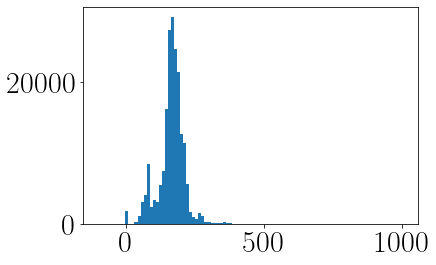

In [10]:
# plt.hist(gaia3.teff_err1 - gaia3.teff_err2, 100, range=(-100, 1000));
plt.hist(np.mean([gaia3.teff_err1, gaia3.teff_err2*-1], axis=0), 100, range=(-100, 1000));
print(np.median(gaia3.teff_err1), np.median(gaia3.teff_err2))

# Drop targets with multiple crossmatches and remove negative parallaxes.

In [11]:
def drop_multi_matches(df, ang_sep_column, duplicated_column):
    df_sorted = df.sort_values(by=ang_sep_column, ascending=True)
    df_dropped = df_sorted.drop_duplicates(subset=duplicated_column, keep="first")
    return df_dropped

Text(0.5, 0, 'Angular separation [arcseconds]')

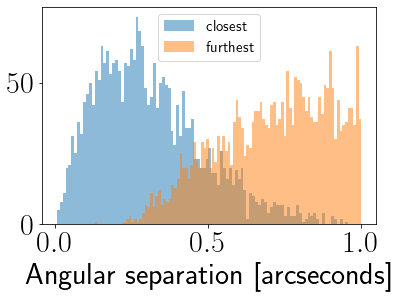

In [12]:
# Plot the distribution of angular distances for the nearest and furthest duplicated stars
gaia3_sorted = gaia3.sort_values(by="kepler_gaia_ang_dist", ascending=True)
furthest = gaia3_sorted.duplicated(subset="kepid", keep="first")
closest = gaia3_sorted.duplicated(subset="kepid", keep="last")
plt.hist(gaia3_sorted.kepler_gaia_ang_dist.values[closest], 100, alpha=.5, label="closest");
plt.hist(gaia3_sorted.kepler_gaia_ang_dist.values[furthest], 100, alpha=.5, label="furthest");
plt.legend()
plt.xlabel("Angular separation [arcseconds]")

In [13]:
# If a target is duplicated, keep the one with the smallest angular separation.
# Drop stars with the same Kepler ID
gaia_dropped = drop_multi_matches(gaia3, "kepler_gaia_ang_dist", "kepid")
print(len(gaia3)-len(gaia_dropped), "Stars with the same Kepler ID dropped")

# Drop stars with the same Gaia ID
gaia = drop_multi_matches(gaia_dropped, "kepler_gaia_ang_dist", "source_id")
print(len(gaia_dropped)-len(gaia), "Stars with the same Gaia ID dropped")

m = gaia.parallax.values > 0.
gaia = gaia.iloc[m]

2573 Stars with the same Kepler ID dropped
744 Stars with the same Gaia ID dropped


Save the single matches as a separate file.

In [14]:
gaia.to_csv("../data/gaia_kepler_unique_matches.csv")

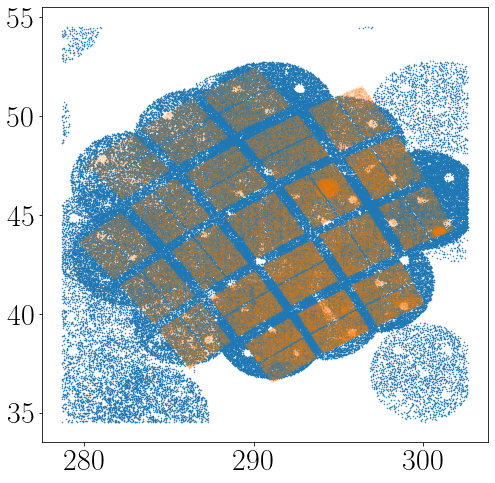

In [15]:
plt.figure(figsize=(8,8))
plt.plot(lamost_kepler_sky.ra, lamost_kepler_sky.dec, ".", ms=1, zorder=0)
plt.plot(gaia.ra, gaia.dec, ".", zorder=1, ms=1, alpha=.1)

# Transform Gaia positions to J2000

In [16]:
gaia_coords_3d = SkyCoord(ra=gaia['ra'].values*u.deg, dec=gaia['dec'].values*u.deg,
                          distance=Distance(1./gaia.parallax.values, unit="kpc", allow_negative=True),
                          pm_ra_cosdec=gaia['pmra'].values*u.mas/u.yr, pm_dec=gaia['pmdec'].values*u.mas/u.yr,
#                           radial_velocity=gaia['dr2_radial_velocity'].values*u.km/u.s,
                          obstime=Time('J2015.5'))

In [17]:
lamost_epoch = Time("2000-01-01 00:00:00")
gaia_epoch = Time("2015-02-07 21:00:00")
gaia_coords_J2000 = gaia_coords_3d.apply_space_motion(lamost_epoch)

# Now perform the crossmatch.

In [18]:
lamost_coords = SkyCoord(lamost_kepler_sky.ra.values, lamost_kepler_sky.dec.values, unit="deg")

idx, sep2d, _ = gaia_coords_J2000.match_to_catalog_sky(lamost_coords)

In [19]:
gaia["gaia_lamost_angular_separation_arcsec"] = sep2d.arcsec

# Combine the Gaia and LAMOST catalogs

In [20]:
lamost_crossmatched = lamost_kepler_sky.iloc[idx]
lamost_crossmatched["idx"] = range(len(lamost_crossmatched))
gaia["idx"] = range(len(gaia))
lamost_gaia = pd.merge(gaia, lamost_crossmatched, on="idx", suffixes=["", "_lamost"])

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


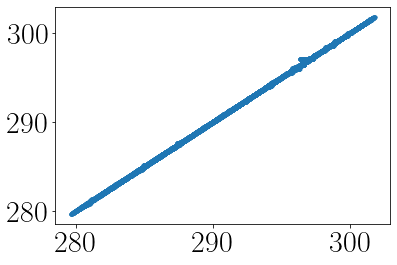

In [21]:
# Check stars have similar RAs to make sure you did the xmatch correctly!
plt.plot(lamost_gaia.ra, lamost_gaia.ra_lamost, ".")

# Remove stars with large angular separations and duplicate matches.

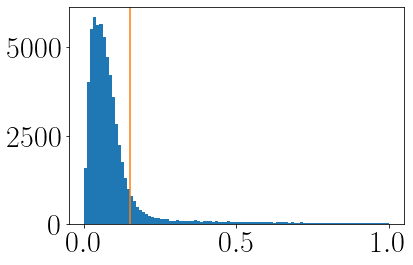

In [22]:
plt.hist(lamost_gaia.gaia_lamost_angular_separation_arcsec, 100, range=(0, 1));
plt.axvline(.15, color="C1")

In [23]:
m = lamost_gaia.gaia_lamost_angular_separation_arcsec.values < 1.5
good_matches = lamost_gaia.iloc[m]
print(len(lamost_gaia), len(good_matches))

good_matches = drop_multi_matches(good_matches, "gaia_lamost_angular_separation_arcsec", "source_id")
print(len(good_matches))

good_matches = drop_multi_matches(good_matches, "gaia_lamost_angular_separation_arcsec", "designation")
print(len(good_matches))

194301 64111
64111
64111


-111.54862879039258 224.35655424529506
1894 62217


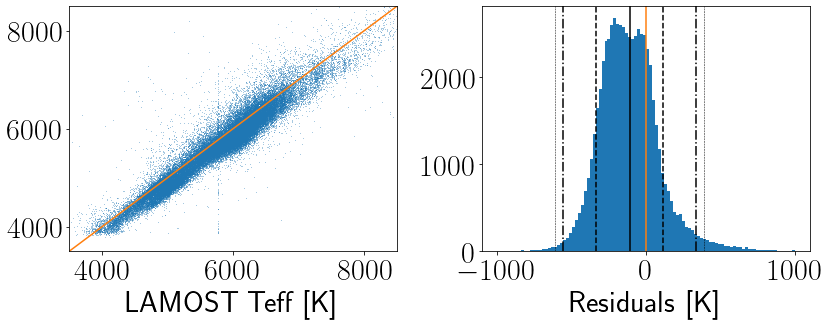

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(good_matches.teff, good_matches.teff_lamost, ".", ms=2, alpha=.5, mec="none")
xs = np.linspace(3500, 8500)
plt.plot(xs, xs)
plt.xlim(3500, 8500)
plt.ylim(3500, 8500)
plt.xlabel("Gaia Teff [K]")
plt.xlabel("LAMOST Teff [K]")

plt.subplot(1, 2, 2)
plt.hist(good_matches.teff_lamost-good_matches.teff, 100, range=(-1000, 1000));
plt.xlabel("Residuals [K]")
plt.axvline(0, color="C1")

residuals = good_matches.teff_lamost.values-good_matches.teff.values
mean, std = np.mean(residuals), np.std(residuals)
print(mean, std)
plt.axvline(mean, color="k")
plt.axvline(mean+std, color="k", linestyle="--")
plt.axvline(mean-std, color="k", linestyle="--")
plt.axvline(mean+2*std, color="k", linestyle="-.")
plt.axvline(mean-2*std, color="k", linestyle="-.")
plt.axvline(mean+500, color="k", linestyle="--", lw=.5)
plt.axvline(mean-500, color="k", linestyle="--", lw=.5)

plt.tight_layout()

m = (residuals < mean + 500) & (mean - 500 < residuals)
print(len(residuals) - sum(m), sum(m))

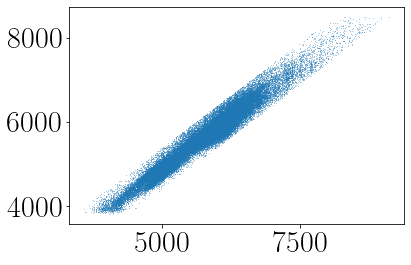

In [29]:
plt.plot(good_matches.teff.values[m], good_matches.teff_lamost.values[m], ".", ms=2, alpha=.5, mec="none")

In [30]:
lamost_gaia_kepler_crossmatch = good_matches.iloc[m]
lamost_gaia_kepler_crossmatch.to_csv("../data/lamost_gaia_kepler_crossmatch.csv")

# Let's take a look at the APOGEE crossmatch here too

(22.0, 3.0)

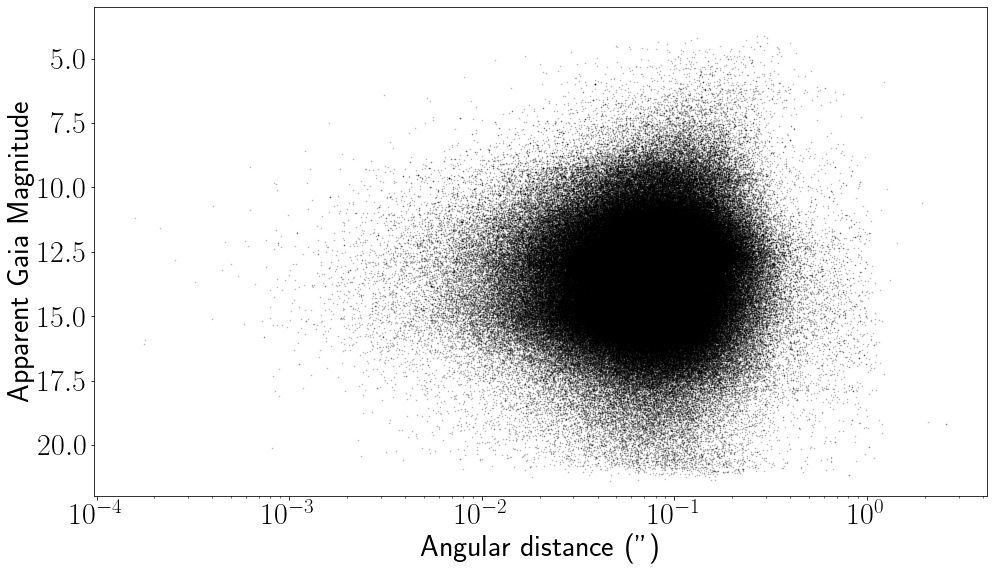

In [67]:
tbl = Table.read("../data/apogee_dr16_tmass_psc_edr3_xmatch.fits", format='fits')  # This is Joel's new version
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
apo3 = tbl[names].to_pandas()

tbl = Table.read("../data/apogeedr16_stars.fits", format='fits')
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
apo2 = tbl[names].to_pandas()

apo = pd.merge(apo2, apo3, how="left", left_on="GAIA_SOURCE_ID", right_on="dr2_source_id")

plt.figure(figsize=(16, 9))
plt.plot(apo.tmass_edr3_angular_distance, apo.GAIA_PHOT_G_MEAN_MAG, "k.", ms=3, alpha=.3, mec="none")

plt.xscale("log")
plt.xlabel("Angular distance ('')")
plt.ylabel("Apparent Gaia Magnitude")
plt.ylim(22, 3)

In [71]:
with fits.open("../../data/kepler_edr3_1arcsec.fits") as data:
    gaia_kep = pd.DataFrame(data[1].data, dtype="float64")
    
df = pd.merge(gaia_kep, apo, left_on="source_id", right_on="dr2_source_id")

1457 20414


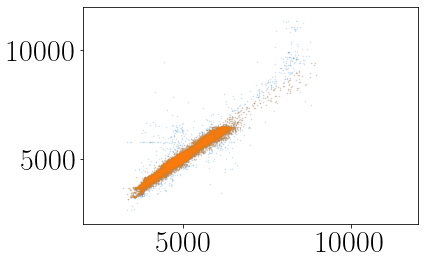

In [86]:
plt.plot(df.TEFF, df.teff, ".", ms=1, alpha=.2)
plt.xlim(2000, 12000)
plt.ylim(2000, 12000)

apo_residuals = df.TEFF.values - df.teff.values
m_apo = (apo_residuals < mean + 500) & (mean - 500 < apo_residuals)
print(len(apo_residuals) - sum(m_apo), sum(m_apo))
plt.plot(df.TEFF.values[m_apo], df.teff.values[m_apo], ".", ms=1, alpha=.2)

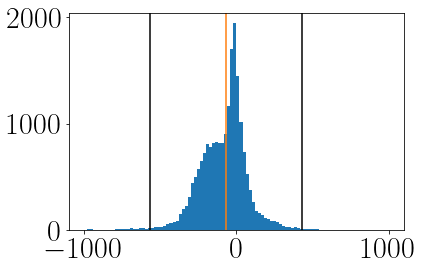

In [84]:
plt.hist(df.TEFF - df.teff, 100, range=(-1000, 1000));
plt.axvline(np.median(apo_residuals), color="C1")
plt.axvline(np.median(apo_residuals)+500, color="k")
plt.axvline(np.median(apo_residuals)-500, color="k")

In [68]:
np.array([k for k in apo.keys()])

array(['APOGEE_ID', 'TELESCOPE', 'FIELD', 'J', 'J_ERR', 'H', 'H_ERR', 'K',
       'K_ERR', 'RA', 'DEC', 'GLON', 'GLAT', 'APOGEE_TARGET1',
       'APOGEE_TARGET2', 'APOGEE_TARGET3', 'APOGEE2_TARGET1',
       'APOGEE2_TARGET2', 'APOGEE2_TARGET3', 'TARGFLAGS', 'SURVEY',
       'PROGRAMNAME', 'NVISITS', 'COMBTYPE', 'COMMISS', 'SNR', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER',
       'VERR', 'VERR_MED', 'OBSVHELIO_AVG', 'OBSVSCATTER', 'OBSVERR',
       'OBSVERR_MED', 'SYNTHVHELIO_AVG', 'SYNTHVSCATTER', 'SYNTHVERR',
       'SYNTHVERR_MED', 'RV_TEFF', 'RV_LOGG', 'RV_FEH', 'RV_ALPHA',
       'RV_CARB', 'RV_CCFWHM', 'RV_AUTOFWHM', 'SYNTHSCATTER', 'MEANFIB',
       'SIGFIB', 'SNREV', 'APSTAR_VERSION', 'ASPCAP_VERSION',
       'RESULTS_VERSION', 'EXTRATARG', 'MIN_H', 'MAX_H', 'MIN_JK',
       'MAX_JK', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'VMICRO',
       'VMACRO', 'VSINI', 'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR',
       'ASPCAP_CHI2', 'ASPCAP_CLASS', 'A

In [88]:
short = apo.loc["APOGEE_ID":"LOGG_SPEC"]
np.array([k for k in short.keys()])

array(['APOGEE_ID', 'TELESCOPE', 'FIELD', 'J', 'J_ERR', 'H', 'H_ERR', 'K',
       'K_ERR', 'RA', 'DEC', 'GLON', 'GLAT', 'APOGEE_TARGET1',
       'APOGEE_TARGET2', 'APOGEE_TARGET3', 'APOGEE2_TARGET1',
       'APOGEE2_TARGET2', 'APOGEE2_TARGET3', 'TARGFLAGS', 'SURVEY',
       'PROGRAMNAME', 'NVISITS', 'COMBTYPE', 'COMMISS', 'SNR', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER',
       'VERR', 'VERR_MED', 'OBSVHELIO_AVG', 'OBSVSCATTER', 'OBSVERR',
       'OBSVERR_MED', 'SYNTHVHELIO_AVG', 'SYNTHVSCATTER', 'SYNTHVERR',
       'SYNTHVERR_MED', 'RV_TEFF', 'RV_LOGG', 'RV_FEH', 'RV_ALPHA',
       'RV_CARB', 'RV_CCFWHM', 'RV_AUTOFWHM', 'SYNTHSCATTER', 'MEANFIB',
       'SIGFIB', 'SNREV', 'APSTAR_VERSION', 'ASPCAP_VERSION',
       'RESULTS_VERSION', 'EXTRATARG', 'MIN_H', 'MAX_H', 'MIN_JK',
       'MAX_JK', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'VMICRO',
       'VMACRO', 'VSINI', 'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR',
       'ASPCAP_CHI2', 'ASPCAP_CLASS', 'A

# Now combine everything into one table. 